<a href="https://colab.research.google.com/github/sfch1999/Condos.ca-Prediction/blob/main/decision_tree_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
# load data
data = pd.read_csv('condoData.csv')

data = data.drop(columns=['Unnamed: 0', 'Possession','Corp #:','Show all', 'price', 'Broker', 'MLS Number', 'address', 'Parking:','Size:'])
print(data.head(10))
print(data.columns)

# Data Processing

In [3]:
# make actual size numeric
for i in range(data.shape[0]):
  if "-" in data.at[i,'Actual size']:
    values = data.at[i,'Actual size'].split("-")
    data.at[i,'Actual size'] = (int(values[0]) + (int(values[1])+1))//2

data['Actual size'] = data['Actual size'].astype(int)

print(data['Actual size'])


0       2536
1        597
2        465
3       1100
4        610
        ... 
3602     765
3603    1500
3604     842
3605     900
3606     750
Name: Actual size, Length: 3607, dtype: int64


In [4]:
# make Maintenance fees numeric
data['Maintenance fees'] = data['Maintenance fees'].str.replace(',', '')
data['Maintenance fees'] = data['Maintenance fees'].str.replace('$', '')
data['Maintenance fees'] = data['Maintenance fees'].astype(float)

print(data['Maintenance fees'])

0       2071.29
1        437.08
2        353.00
3       1052.99
4        425.62
         ...   
3602     479.29
3603     548.22
3604     705.53
3605     701.14
3606     583.98
Name: Maintenance fees, Length: 3607, dtype: float64


In [5]:
# make Age of building numeric
for i in range(data.shape[0]):
  values = data.at[i,'Age of building'].split(" ")
  age = values[0]
  if age == "-":
    age=np.nan
  elif age=="New":
    age=0
  elif "-" in age:
    values = age.split("-")
    age = (int(values[0])+int(values[1]))//2
  elif "+" in age:
    age = age.split("+")[0]

  data.at[i,'Age of building'] = age

data['Age of building'] = data['Age of building'].astype(float)

print(data['Age of building'].unique())

[  9.  24.   4.  34.   5.   7.   0.  nan   3.  42.  19.  11.  44.  12.
  15.  49.  20.   8.   1.  10.  14.  23.  31.   2.  16.  30.  17.  29.
  21.  25.  43.  36.  40.  33.   6.  28.  46.  13.  47.  22.  45.  18.
  50.  32.  37.  39.  48.  35.  38.  41.  51.  52.  26.  75.  27. 100.]


In [6]:
# make Price/sqm numeric
data['Price/sqm'] = data['Price/sqm'].str.replace(',', '')
data['Price/sqm'] = data['Price/sqm'].str.replace('$', '')

for i in range(data.shape[0]):
  if "-" in str(data.at[i,'Price/sqm']):
    values = data.at[i,'Price/sqm'].split("-")
    data.at[i,'Price/sqm'] = (int(values[0])+int(values[1]))//2

data['Price/sqm'] = data['Price/sqm'].astype(float)


print(data['Price/sqm'])

0        7606.0
1        9273.0
2       11605.0
3        6126.0
4       10702.0
         ...   
3602    11266.0
3603    10788.0
3604     6729.0
3605     5713.0
3606    11100.0
Name: Price/sqm, Length: 3607, dtype: float64


In [7]:
# create Den column and make Bed numeric
data['Den'] = np.zeros(data.shape[0])

for i in range(data.shape[0]):
  if "+" in str(data.at[i,'Bed']):
    values = data.at[i,'Bed'].split("+")
    data.at[i,'Bed'] = values[0]
    data.at[i,'Den'] = values[1]
  elif data.at[i,'Bed'] == 'Studio':
    data.at[i,'Bed'] = 0 

data['Bed'] = data['Bed'].astype(int)
data['Den'] = data['Den'].astype(int)

print(data['Bed'].unique())
print(data['Den'].unique())



[2 1 3 0 4 5]
[1 0 3 2]


In [8]:
# generate list of unique amenities, and make a col for each
amenities = []

for i in range(data.shape[0]):
  amenities_condo = []
  amenities_condo = data.at[i,'amenities'].split(",")

  for j in range(len(amenities_condo)):
    item = amenities_condo[j].strip(" ")
    data.at[i,item] = 1

    if item not in amenities:
      amenities.append(item)


for a in range(len(amenities)):
  data[amenities[a]] = data[amenities[a]].fillna(0)
  data[amenities[a]] = data[amenities[a]].astype(int)


In [9]:
# generate list of unique services incl in maintence fees, and make a col for each
maintence = []

for i in range(data.shape[0]):
  maintence_condo = []
  maintence_condo = data.at[i,'included_in_maintenance_fees'].split(",")

  for j in range(len(maintence_condo)):
    item = maintence_condo[j].strip(" ")
    data.at[i,item] = 1

    if item not in amenities:
      maintence.append(item)


for a in range(len(maintence)):
  data[maintence[a]] = data[maintence[a]].fillna(0)
  data[maintence[a]] = data[maintence[a]].astype(int)



In [10]:
data = data.drop(columns=['amenities', 'included_in_maintenance_fees'])

In [11]:
# one hot encode categorical data
data = pd.get_dummies(data, columns=['Exposure','Outdoor space', 'Locker', 'Heating type:',
       'Parking type:', 'Property type:', 'Area:', 'Ensuite laundry:'], drop_first=True)




In [12]:
data_no_na = data.dropna(axis=0)
print(data.shape)
print(data_no_na.shape)

(3607, 246)
(3447, 246)


In [13]:
print(data_no_na.columns)

Index(['Actual size', 'Maintenance fees', 'Age of building', 'Price/sqm',
       'Bed', 'Bath', 'Parking', 'Den', 'Concierge', 'Gym',
       ...
       'Area:_Woburn', 'Area:_Woodbine Corridor', 'Area:_Wychwood',
       'Area:_Yonge and Bloor', 'Area:_Yonge-Eglinton',
       'Area:_Yonge-St. Clair', 'Area:_York University Heights',
       'Area:_Yorkdale | Glen Park', 'Area:_Yorkville',
       'Ensuite laundry:_Yes'],
      dtype='object', length=246)


In [14]:
# save data_no_na to a csv file
data_no_na.to_csv("data_with_amenities",sep=",", mode='w', header=False) 

# Decision Tree Regression Model

In [15]:
# split x andd y data
y_data = data_no_na['Price/sqm']
X_data = data_no_na.drop(columns=['Price/sqm'])

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42)

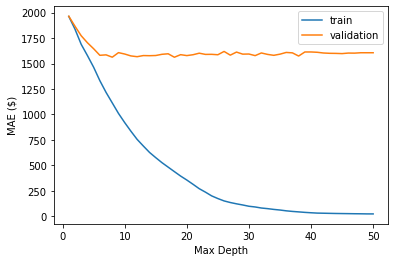

best depth =  18
Validation MAE at best depth =  1561.8088363434683
Test MAE at best depth =  1445.338947570726


In [26]:
# run cross validation to determine best maximum depth
mae_train_dt = np.zeros(50)
mae_val_dt = np.zeros(50)
max_depth_dt = np.arange(1,51)

for i in range(50):
  regressor = DecisionTreeRegressor(random_state=0, max_depth=i+1)
  regressor.fit(X_train, y_train)
  
  y_pred_train = regressor.predict(X_train)
  cv_score = cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
  
  mae_val_dt[i] = cv_score
  mae_train_dt[i] = mean_absolute_error(y_train, y_pred_train)

# cross validation returns the negative MAE - make positive
mae_val_dt = mae_val_dt*(-1)

# plot results of cross validation
plt.plot(max_depth_dt, mae_train_dt, label = "train")
plt.plot(max_depth_dt, mae_val_dt, label = "validation")
plt.xlabel("Max Depth")
plt.ylabel("MAE ($)")
plt.legend()
plt.show()

best_depth_idx = np.argmin(mae_val_dt)
print("best depth = ", max_depth_dt[best_depth_idx])
print("Validation MAE at best depth = ", mae_val_dt[best_depth_idx])

# fit the data to a DT with the best max_depth
regressor = DecisionTreeRegressor(random_state=0, max_depth=max_depth_dt[best_depth_idx])
regressor.fit(X_train, y_train)

# test this model on the test set data
y_pred_test = regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test MAE at best depth = ", mae_test)

# Random Forrest Regression Model

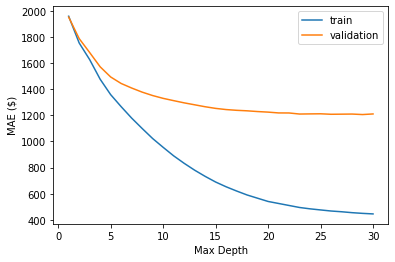

best depth =  29
test MAE at best depth =  1205.670320591899
Test MAE at best depth =  1089.3952443618982


In [27]:
# run cross validation to determine best maximum depth
mae_train_rf = np.zeros(30)
mae_val_rf = np.zeros(30)
max_depth_rf = np.arange(1,31)

for i in range(30):
  regressor = RandomForestRegressor(random_state=0, max_depth=i+1)
  regressor.fit(X_train, y_train)
  
  y_pred_train = regressor.predict(X_train)
  cv_score = cross_val_score(regressor, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()

  mae_val_rf[i] = cv_score
  mae_train_rf[i] = mean_absolute_error(y_train, y_pred_train)

# cross validation returns the negative MAE- make positive
mae_val_rf = mae_val_rf*(-1)

# plot results of cross validation
plt.plot(max_depth_rf, mae_train_rf, label = "train")
plt.plot(max_depth_rf, mae_val_rf, label = "validation")
plt.xlabel("Max Depth")
plt.ylabel("MAE ($)")
plt.legend()
plt.show()

best_depth_idx = np.argmin(mae_val_rf)
print("best depth = ", max_depth_rf[best_depth_idx])
print("validation MAE at best depth = ", mae_val_rf[best_depth_idx])

# fit the data to a RF with the best max_depth
regressor = RandomForestRegressor(random_state=0, max_depth=max_depth_dt[best_depth_idx])
regressor.fit(X_train, y_train)

# test this model on the test set data
y_pred_test = regressor.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
print("Test MAE at best depth = ", mae_test)

In [31]:
# random forrest with best max depth
regressor = RandomForestRegressor(random_state=0, max_depth=i+1)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred_train = regressor.predict(X_train)

mae_test = mean_absolute_error(y_test, y_pred)
mae_train = mean_absolute_error(y_train, y_pred_train)

print("mae_train = ", mae_train)
print("mae_test = ", mae_test)

mae_train =  445.8920977520709
mae_test =  1090.0855415058898


In [32]:
# feature importance from random forrest regressor
importances = regressor.feature_importances_

importances_df = pd.DataFrame({'feature': X_data.columns, 'importance': importances})
importances_df = importances_df.sort_values('importance', axis=0, ascending=False)

print("Most important features:")
display(importances_df.head(15))
importances_df.to_csv("import.csv",sep=",", mode='w', header=False) 

n = importances_df.shape[0]
#print("Least important features:")
#print(importances_df.tail(15))

Most important features:


,feature,importance
2,Age of building,0.412182
1,Maintenance fees,0.132897
0,Actual size,0.100856
7,Concierge,0.029535
243,Area:_Yorkville,0.027394
17,Outdoor Pool,0.014037
4,Bath,0.013809
22,Rooftop Deck,0.011862
203,Area:_Queen West,0.010076
26,Beanfield Fibre Available,0.008765


# Plot for report

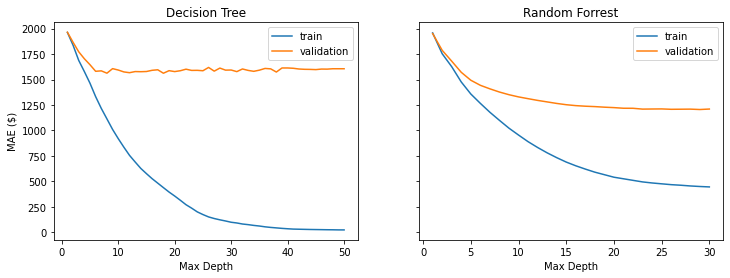

In [29]:
# create a figure with both plots side by side

fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row')
fig.set_figheight(4)
fig.set_figwidth(12)

ax1.plot(max_depth_dt, mae_train_dt, label = "train")
ax1.plot(max_depth_dt, mae_val_dt, label = "validation")
ax1.set(xlabel="Max Depth", ylabel="MAE ($)")
ax1.legend()
ax1.set_title("Decision Tree")


ax2.plot(max_depth_rf, mae_train_rf, label = "train")
ax2.plot(max_depth_rf, mae_val_rf, label = "validation")
ax2.set(xlabel="Max Depth")

ax2.legend()
ax2.set_title("Random Forrest")


plt.show()

